Import packages

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import logging

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
logging.getLogger('matplotlib.category').setLevel(logging.ERROR)

import utils

Set seed:

In [4]:
seed = 2025
np.random.seed(seed)

# Dataset

### Dataload:

In [ ]:
# Data retrieval
import os, requests

fname = 'faceshouses.npz'
url = "https://osf.io/argh7/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

# Data loading
alldata = np.load(fname, allow_pickle=True)['dat'] #array shape (7,2)

### Dataset info :

alldata contains recordings from 7 subjects across 2 experiments.

This dataset is one of several publicly available electrocorticography (ECoG) datasets from the Kai J. Miller Library (2019).  
It includes data from 7 subjects (epileptic patients) with ECoG recordings. Each subject performed two experiments :
- In the first experiment, subjects were passively shown images of faces and houses without added noise.
- In the second experiment, 315 face images and 315 house images were presented with varying levels of added noise. Each image was displayed for one second, with no inter-stimulus interval. Subjects were instructed to press a button if they believed the image to be a face. There was neither incentive nor encouragement to respond faster. Two of the subjects don't have keypresses.

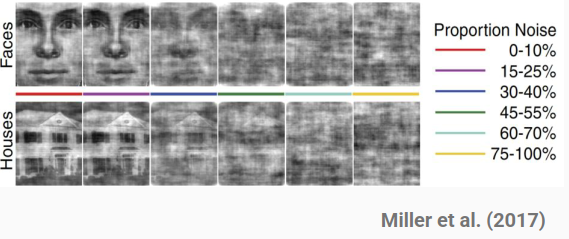

ECoG electrodes were placed in various regions for seizure monitoring and in inferior temporal face-selective sites. For further details, refer to the original publications of Kai Miller and al.

Sample rate is always 1000Hz, and the ECoG dataset we used in this project was curated by Neuromatch Academy and downloaded from the [Open Science Framework (OSF)](https://osf.io/argh7). It was already notch-filtered at 60, 120, 180, 240 and 250Hz, followed by z-scoring across time and conversion to float16 to minimize size.

---

In this short project, we aimed to assess the relationship between noise level in face images correctly identified by subjects as faces and the latency to reach the first peak of event-related high-gamma band power. 

Therefore, our analysis focused on the second experiment, which includes behavioral responses (face identification via keypress).

---

Data from the second experiment:

In [13]:
alldata_exp2 = alldata[:,1]  #array, shape (7,)
utils.alldata_exp2 = alldata_exp2 

Let's explore the data from the second experiment for Subject 1:

In [14]:
subject_idx = 0
utils.describe_one_subject_data(subject_idx)

stim_id             : type=<class 'numpy.ndarray'>        shape = (630,)          First values = [1 2 3 4 5]
stim_cat            : type=<class 'numpy.ndarray'>        shape = (630, 1)        First values = [1 1 2 1 1]
stim_noise          : type=<class 'numpy.ndarray'>        shape = (630, 1)        First values = [100   5  85  65  40]
t_on                : type=<class 'numpy.ndarray'>        shape = (630,)          First values = [3080 4080 5080 6080 7080]
t_off               : type=<class 'numpy.ndarray'>        shape = (630,)          First values = [4080 5080 6080 7080 8080]
key_press           : type=<class 'numpy.ndarray'>        shape = (133,)          First values = [ 8520  9920 11920 12960 18760]
V                   : type=<class 'numpy.ndarray'>        shape = (666240, 41)   
categories          : type=<class 'dict'>                 len = 2                 {'1': 'house', '2': 'face'}
scale_uv            : type=<class 'numpy.ndarray'>        shape = (41,)           First values

    'stim_id: stimulus ID
    'stim_cat': stimulus category (1 = house, 2 = face)
    'stim_noise': percent noise from 0 to 100
    't_on': time of stimulus onset in data samples
    't_off': time of stimulus offset, always 1000 samples after t_on, with no inter-stimulus interval
    'key_press': time when the subject pressed the key (i.e. thought the image was a face)
    'V': continuous voltage data (time by channels)
    'categories': categories legend (1 = house, 2 = face)
    'scale_uv': scaling factor for voltage values
    'locs': 3D electrode positions on the brain surface
    'hemisphere', 'lobe', 'gyrus' and 'Brodmann_Area': anatomical location of each electrode

# 1- Exploring Subject Keypress Behavior

### 1.1- Keypressing data available for only 5 out of 7 subjects

Subjects 2 and 3 did not have a keypresser and were excluded from our analysis, as their data cannot address our question.

In [15]:
all_subjects_data = alldata_exp2 #array, shape (7,)

key_subjects_data = []
key_subjects_index = []

for i, subj in enumerate(all_subjects_data) :
    if subj['key_press'].size > 0 :
        key_subjects_data.append(subj) 
        key_subjects_index.append(i)

key_subjects_data = np.array(key_subjects_data) #array, shape (5,)
key_subjects_labels = [f"S{idx+1}" for idx in key_subjects_index] #for plotting
key_subjects_colors = ['blue', 'green', 'saddlebrown', 'gray', 'goldenrod'] #for plotting 
key_subjects_No = [idx+1 for idx in key_subjects_index]
n_key_subjects = len(key_subjects_index)

sorted_noise_levels, sorted_noise_levels_labels, n_noise_levels = utils.get_noise_levels(all_subjects_data)


key_args = {}
key_args['key_subjects_No'] = key_subjects_No
key_args['key_subjects_index'] = key_subjects_index
key_args['key_subjects_labels'] = key_subjects_labels
key_args['key_subjects_colors'] = key_subjects_colors
key_args['sorted_noise_levels'] = sorted_noise_levels
key_args['sorted_noise_levels_labels'] = sorted_noise_levels_labels

for k, v in key_args.items():
    if isinstance(v, np.ndarray):
        v = v.tolist()
    if len(v) < 10 :
        print(f"{k:30}: len = {len(v):2d},     {v}")
    else :
        v_new = [v[0], v[1], v[2], '...', v[-3], v[-2], v[-1]]
        print(f"{k:30}: len = {len(v):2d},     {v_new}")

key_subjects_No               : len =  5,     [1, 4, 5, 6, 7]
key_subjects_index            : len =  5,     [0, 3, 4, 5, 6]
key_subjects_labels           : len =  5,     ['S1', 'S4', 'S5', 'S6', 'S7']
key_subjects_colors           : len =  5,     ['blue', 'green', 'saddlebrown', 'gray', 'goldenrod']
sorted_noise_levels           : len = 21,     [0, 5, 10, '...', 90, 95, 100]
sorted_noise_levels_labels    : len = 21,     ['0%', '5%', '10%', '...', '90%', '95%', '100%']


### 1.2- Keypress accuracy

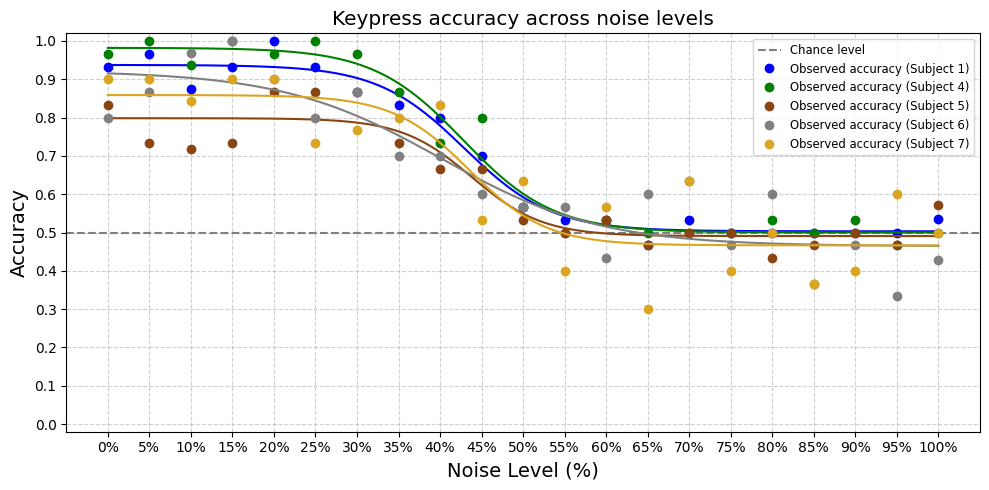

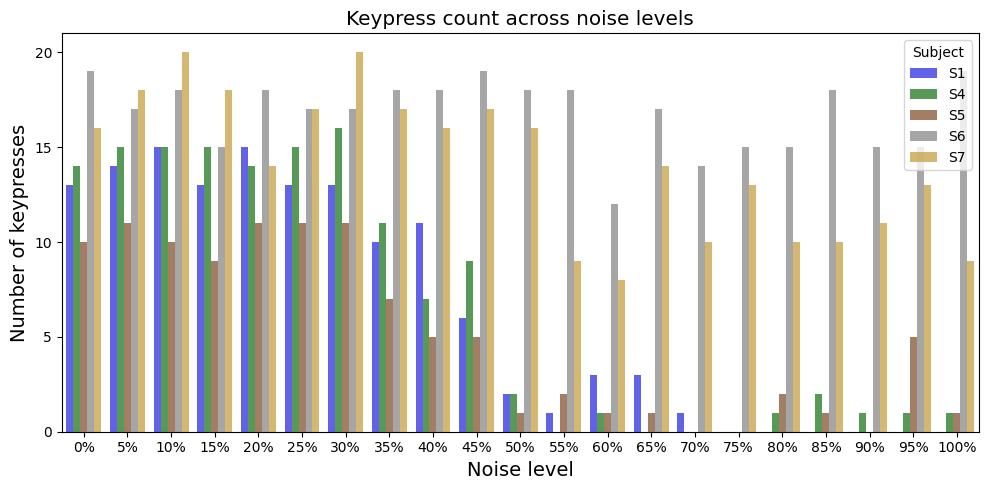

In [16]:
utils.fit_plot_sigmoid_curve(key_subjects_index, 'accuracy', key_args)
utils.get_key_behavior(key_subjects_index, key_args)

Keypress accuracy across subjects approaches chance level (~50%) from around 50–55% noise onward.
- At high noise levels, Subjects 6 and 7 tend to press the key frequently, but their accuracy does not exceed chance level. Their behavior is therefore considered less reliable under high noise.
- At low noise levels, Subject 5 shows relatively bad accuracy, even in the absence of noise. Their behavior is considered less reliable under low noise.
- Therefore, our analysis is restricted to Subjects 1 and 4, who demonstrate the most reliable keypress behavior.

### 1.3 Subjects included in the analysis

Subjects included in the analysis: Subject 1 and Subject 4

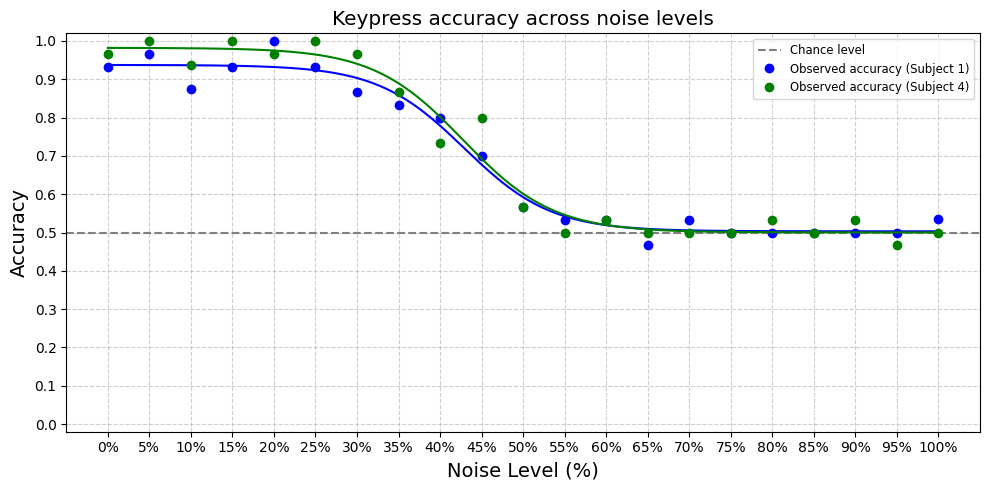

In [17]:
analysed_subjects_idx = [0,3]
utils.fit_plot_sigmoid_curve(analysed_subjects_idx, 'accuracy', key_args)

# 2- Analysis of Subject 4

### 2.1- Data Exploration

Images metadata (Subject 4):


Image_ID Category  Noise  Image_onset  Image_offset  Display_duration  \
0         1    house    100         3080          4080              1000   
1         2    house      5         5080          6080              1000   
2         3     face     85         6080          7080              1000   
3         4    house     65         7080          8080              1000   
4         5    house     40         8080          9080              1000   

   Key_pressed  Interval_keypress  
0            0                NaN  
1            0                NaN  
2            0                NaN  
3            0                NaN  
4            0                NaN




Timeline events metadata (Subject 4):


timeline  image_onset_0_1  image_offset_0_1  keypress_0_1  displayed_image  \
0         1                0                 0             0              NaN   
1         2                0                 0             0              NaN   
2         3                0                 0             0              NaN   
3         4                0                 0             0              NaN   
4         5                0                 0             0              NaN   

        V_1       V_2       V_3       V_4       V_5  ...      V_51      V_52  \
0  0.019775  0.009277  0.009422 -0.012665 -0.031677  ...  0.014961 -0.004913   
1  0.016174  0.008347  0.007385 -0.012741 -0.033325  ... -0.052917 -0.003983   
2  0.010452  0.006443  0.004425 -0.012901 -0.035370  ... -0.129150 -0.003315   
3  0.002581  0.003099  0.000264 -0.013344 -0.038269  ... -0.216675 -0.003338   
4 -0.006664 -0.001371 -0.004726 -0.013924 -0.041779  ... -0.292725 -0.003986   

       V_53      V_54      V_55      V_56      V_57      V_58      V_59  \
0 -0.002104 -0.004639 -0.000980  0.000312 -0.000682 -0.005661  0.002981   
1 -0.002478 -0.004879 -0.001094 -0.004463 -0.004547 -0.003138 -0.004818   
2 -0.004646 -0.005611 -0.001716 -0.010101 -0.008881 -0.001085 -0.014648   
3 -0.008484 -0.006683 -0.002983 -0.016968 -0.014038 -0.000770 -0.027573   
4 -0.012329 -0.006359 -0.003605 -0.022354 -0.018112 -0.002483 -0.039307   

       V_60  
0  0.010933  
1 -0.052643  
2 -0.127075  
3 -0.216919  
4 -0.297852  

[5 rows x 65 columns]

<Figure size 800x800 with 0 Axes>

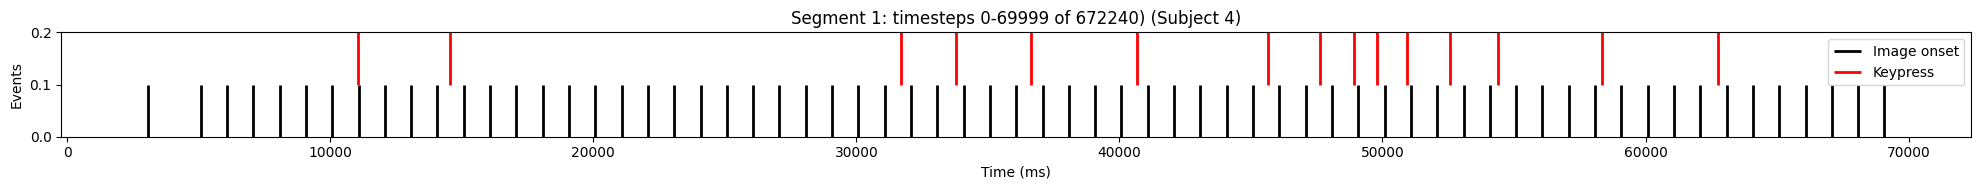




Electrodes metadata (Subject 4):
Subject 4 has 60 electrodes.


electrode_idx      hemisphere           lobe                    gyrus  \
0              0  Right Cerebrum    Limbic Lobe    Parahippocampal Gyrus   
1              1  Right Cerebrum    Limbic Lobe    Parahippocampal Gyrus   
2              2  Right Cerebrum    Limbic Lobe    Parahippocampal Gyrus   
3              3  Right Cerebrum    Limbic Lobe    Parahippocampal Gyrus   
4              4  Right Cerebrum  Temporal Lobe  Inferior Temporal Gyrus   

      Brodmann_Area  
0  Brodmann area 30  
1  Brodmann area 36  
2  Brodmann area 36  
3  Brodmann area 36  
4  Brodmann area 20

In [18]:
subject_idx = 3
selected_subject = utils.select_subject(subject_idx)
selected_subject_data = selected_subject['selected_subject_data'] 

images_df = utils.construct_images_df(selected_subject)
timeline_df = utils.construct_timeline_events_df(selected_subject)
view, electrodes_df = utils.show_electrodes_mapping(selected_subject)

utils.show_metadataframes(subject_idx, images_df, timeline_df, electrodes_df, view)

### 2.2- Face Identification Performance

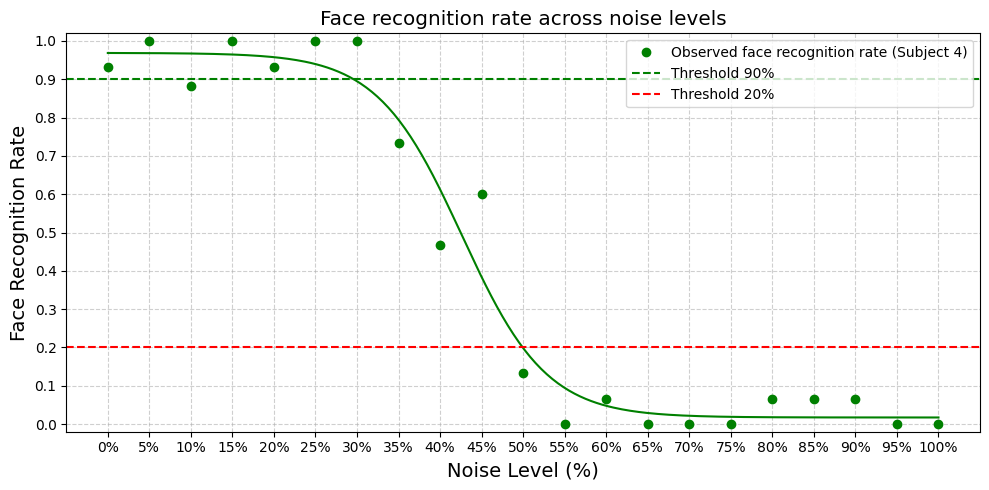

In [19]:
utils.fit_plot_sigmoid_curve([subject_idx], 'face_recognition_rate', key_args, modif=True)
ax = plt.gca()
plt.axhline(0.90, linestyle='--', color='green', label='Threshold 90%')
plt.axhline(0.20, linestyle='--', color='red', label='Threshold 20%')
plt.legend(loc='upper right', fontsize='medium')
plt.show()

In [20]:
utils.display_face_recognition_counts(selected_subject, key_args)

To assess the relationship between visual stimuli noise level and neural response latency, we lack sufficient data for noise levels above 50%, as Subject 4 pressed the button for very few high-noise face images.

We therefore grouped noise levels into broader categories for analysis.

In [21]:
grouped_noise_vals = [                  # Noise level groups (must be sorted in ascending order)
                    [0], 
                    [5,10],
                    [15,20],
                    [25,30],
                    [35,40,45,50],
                ]
grouped_noise_dict = utils.make_noise_combinations_dict(grouped_noise_vals)

utils.display_face_recognition_counts(selected_subject, key_args, grouped_noise_dict)

### 2.3- Effect of noise on keypress latency

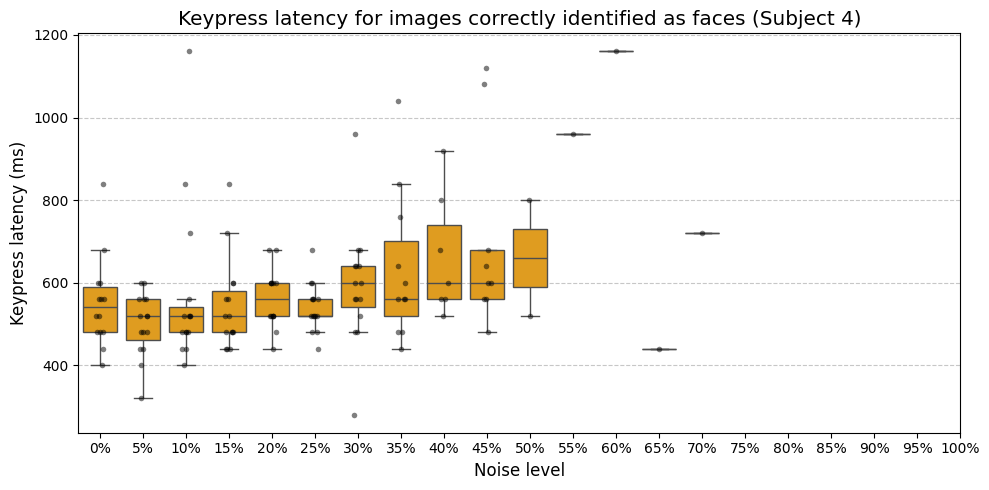

In [22]:
utils.plot_interval_keypress_recog_faces(selected_subject, key_args)

In the experimental setup, subjects were not incentivized or encouraged to respond quickly when identifying faces. Nonetheless, Subject 4 shows a positive correlation between noise level and the interval between image onset and keypress.

### 2.4- Effect of noise on neural response latency 

#### High-Gamma Band Power-Time Analysis

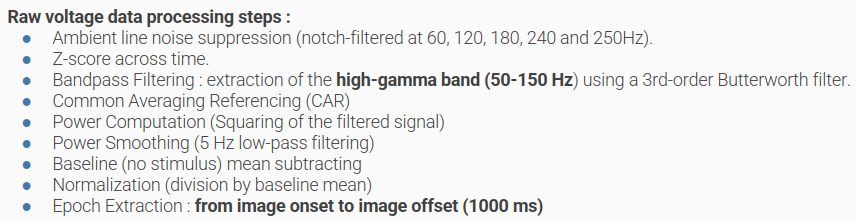

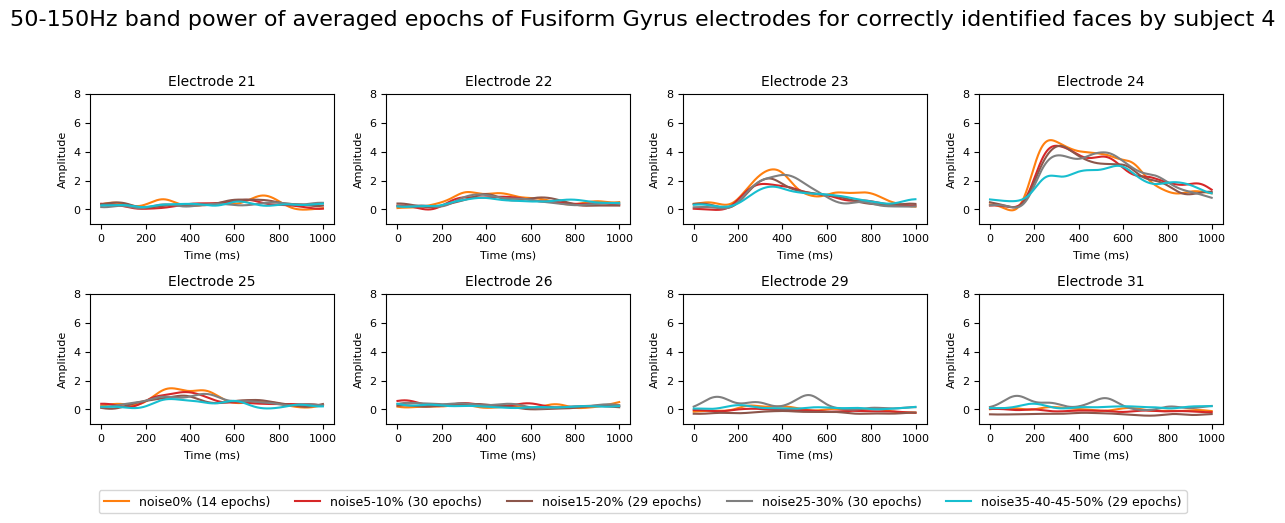

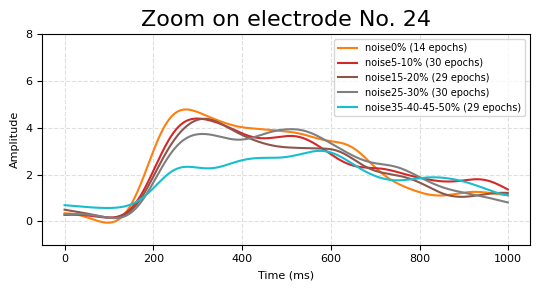

In [23]:
freq_down, freq_up = 50, 150
smooth_power = 5

#Defining grouped noise categories :
grouped_noise_vals = [                # Noise level groups (must be sorted in ascending order)
                    [0], 
                    [5,10],
                    [15,20],
                    [25,30],
                    [35,40,45,50],
                ]
grouped_noise_dict = utils.make_noise_combinations_dict(grouped_noise_vals)
grouped_noise_labels = list(grouped_noise_dict.keys())

#Selecting gyrus electrodes to analyse 
gyrus='Fusiform Gyrus'

#Figure settings :
ylim = (-1, 8)
figsize = (12, 5)

#Power for all electrodes:
power_epochs_averaged_allelec, power_epochs_allelec = utils.get_power_epochs(
    selected_subject,
    freq_down,
    freq_up,
    smooth_power,
    grouped_noise_dict,
    epoch_start_wrt_image_onset = 0,
    epoch_end_wrt_image_onset = 1000,
    gyrus=gyrus,
    category='face',
    key_pressed=1,
    minimum_epochs_to_average=5,
    plot_averaged_power_by_noise=True,
    ylim=ylim,
    figsize=figsize,
    zoom_electrode_idx=[23,0,1000]          #zoom on electrode 24 (index 23)
)


Epochs were extracted from image onset (t=0) to image offset (t=1000) (No inter-stimulus interval in the experimental design).

Electrode 24 in Subject 4 (one of eight electrodes located in the fusiform gyrus) shows a marked response following face image onset but not for house images (data not shown).

This response also appears to exhibit distinct dynamics depending on the stimulus noise level.

We further investigated neural responses recorded from this electrode.

#### Feature selection from High-Gamma Band Power Epochs (Electrode 24)

Two features were analysed in this short project :
- Mean slope of the rising edge of the ﬁrst peak
- First peak latency: time from image onset to the first power peak

These features were examined across different noise categories, using both averaged epochs per noise category and individual epochs.

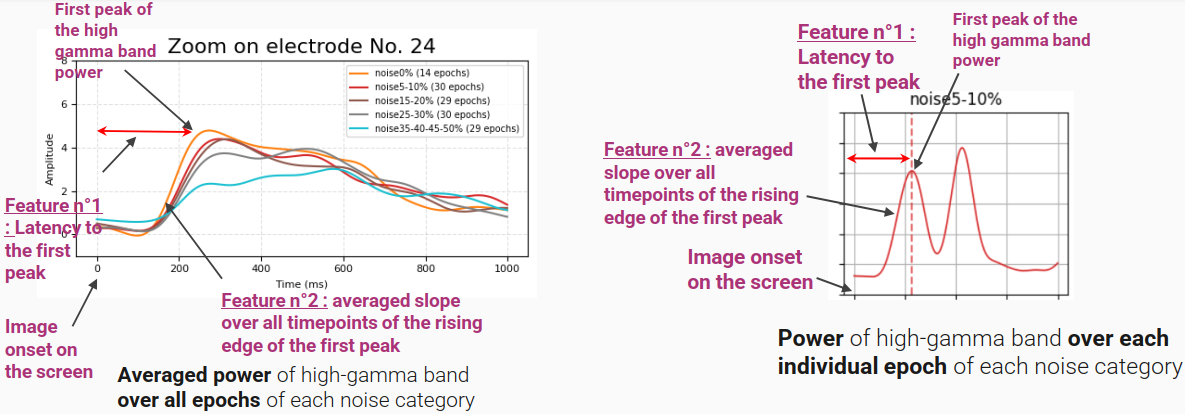

Further analysis could explore additional features.

In [25]:
elec_idx = 23

power_epochs_averaged_oneelec, power_epochs_oneelec = utils.get_power_epochs_oneelec(power_epochs_allelec, elec_idx)

#### 1) Slope analysis of the rising edge of the ﬁrst peak

First, we computed the average slope of the rising edge of the first peak across the averaged high-gamma band power epochs.

The 95% confidence interval was estimated using 10,000 bootstrap iterations for each noise category.

noise0%              : first peak slope = 0.0330 (95% CI 0.0171 - 0.0448)
noise5-10%           : first peak slope = 0.0258 (95% CI 0.0152 - 0.0366)
noise15-20%          : first peak slope = 0.0237 (95% CI 0.0141 - 0.0335)
noise25-30%          : first peak slope = 0.0209 (95% CI 0.0098 - 0.0298)
noise35-40-45-50%    : first peak slope = 0.0127 (95% CI 0.0047 - 0.0242)


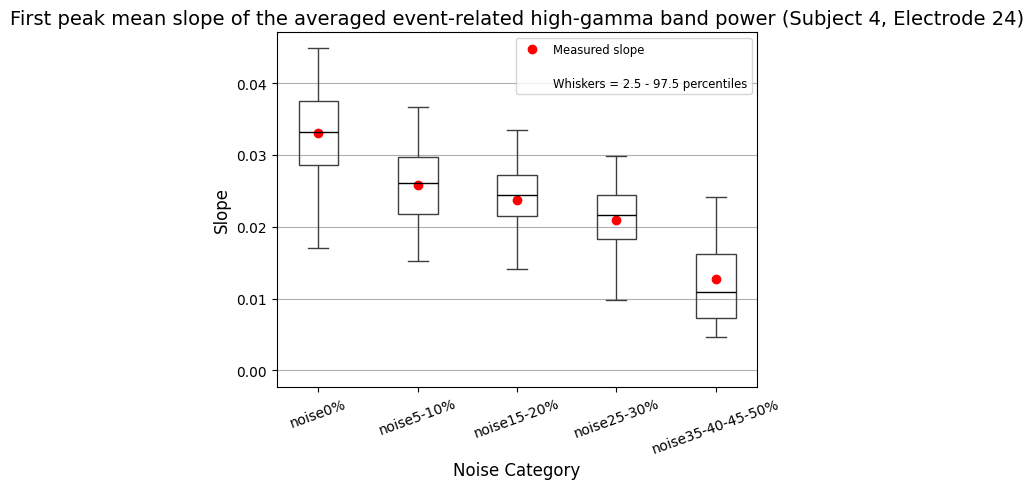

In [26]:
power_slope_first_peak_averagedepochs = utils.get_FirstPeakPowerSlope_AveragedEpochs(power_epochs_averaged_oneelec, plot=False)
boostraps_slopes = utils.get_bootstraps(power_epochs_oneelec, N=10000)
utils.plot_power_slope_averagedepochs_with_bootstrapping(power_slope_first_peak_averagedepochs, boostraps_slopes, subject_idx, elec_idx)

We computed the correlation between noise category and the slope of the rising edge of the first peak in individual high-gamma band power epochs using Spearman’s ρ, and assessed its significance using 1,000 permutations.

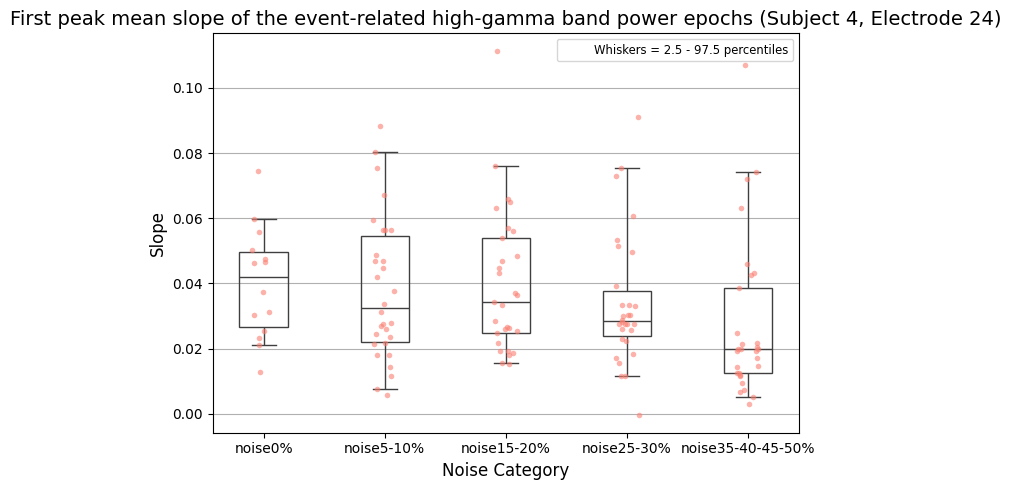

Observed Correlation : -0.2678
p-value permutation (1000 permutations) : 0.00300


In [27]:
_, power_slope_first_peak_individualepochs = utils.get_FirstPeakPowerSlope_IndividualEpochs(power_epochs_oneelec, subject_idx, elec_idx, plot=True)
corr_obs, p_val = utils.spearman_permutation_test(power_slope_first_peak_individualepochs, feature_str='Slope', n_perm=1000, seed=seed)

A significant negative correlation ($\rho$ = –0.268, p = 0.003) was found between noise category and the average slope of the rising edge of the first peak in high-gamma band power epochs recorded from electrode 24 (located in the fusiform gyrus) in Subject 4.

#### 2) Latency analysis of the ﬁrst peak

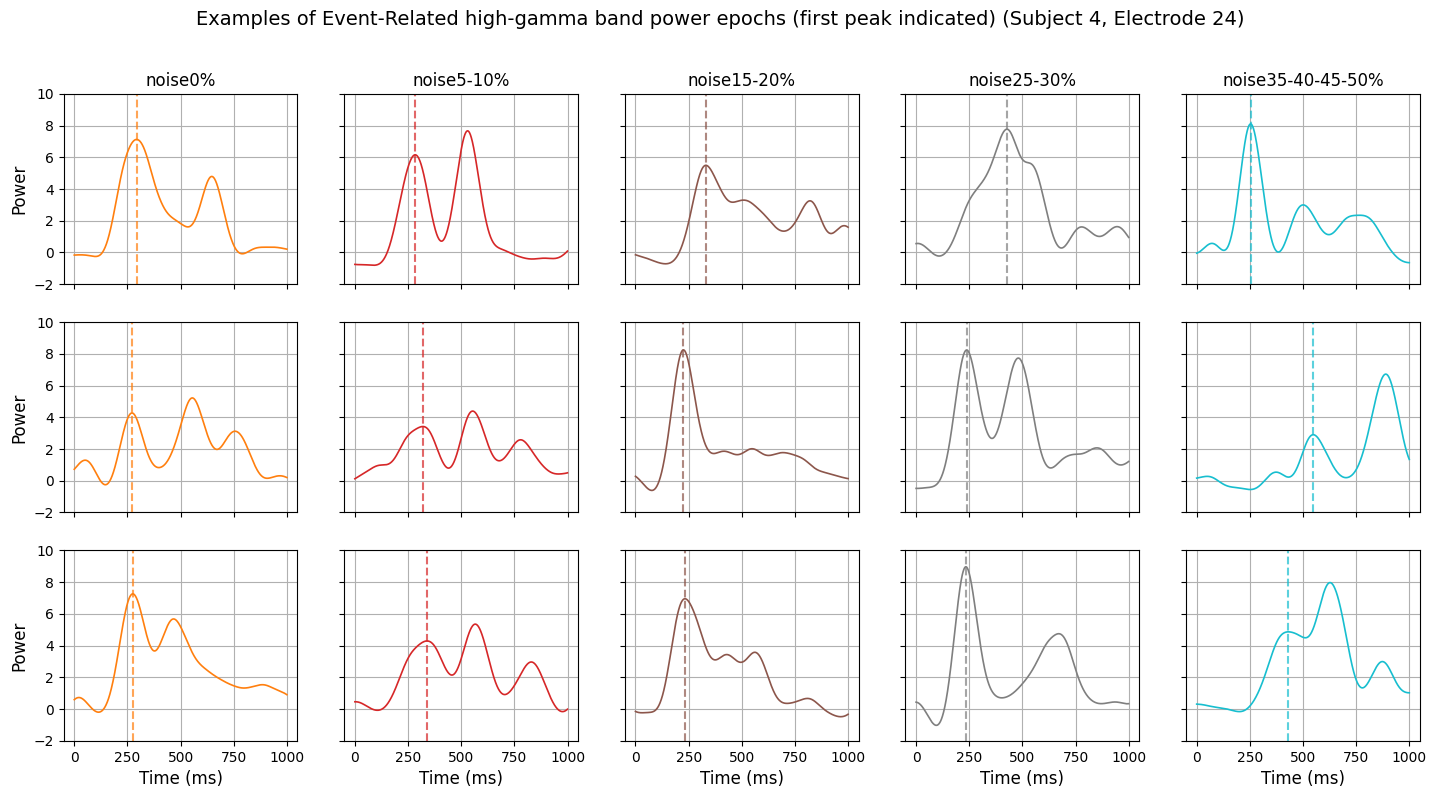

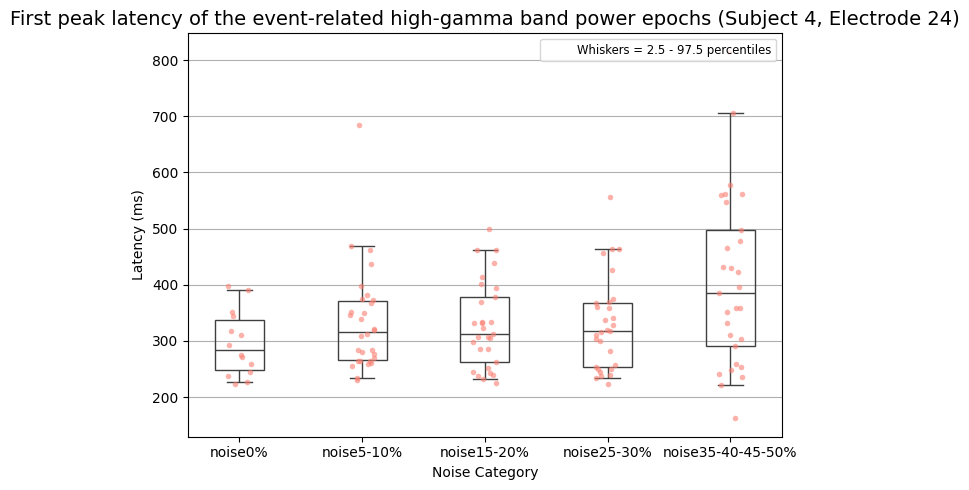

Observed Correlation : 0.2005
p-value permutation (1000 permutations) : 0.01700


In [29]:
_, power_latency_first_peak_individualepochs = utils.get_FirstPeakPowerLatency_IndividualEpochs(power_epochs_oneelec, subject_idx, elec_idx, seed_examples=seed, plot_examples=True, plot=True)
corr_obs, p_val = utils.spearman_permutation_test(power_latency_first_peak_individualepochs, feature_str='Latency', n_perm=1000, seed=seed)

A significant positive correlation ($\rho$ = 0.200, p = 0.017) was observed between noise category and the latency to the first peak in high-gamma band power epochs recorded from electrode 24 (located in the fusiform gyrus) in Subject 4.

# 3- Analysis of Subject No. 1

Similar results were obtained in subject 1 for the electrode 36 (located in the fusiform gyrus).

In [30]:
subject_idx = 0
selected_subject = utils.select_subject(subject_idx)
selected_subject_data = selected_subject['selected_subject_data'] 

view, electrodes_df = utils.show_electrodes_mapping(selected_subject)

utils.show_metadataframes(subject_idx, electrodes_df=electrodes_df, view_electrodes=view)

Electrodes metadata (Subject 1):
Subject 1 has 41 electrodes.


electrode_idx      hemisphere          lobe                   gyrus  \
0              0   Left Cerebrum  Frontal Lobe    Medial Frontal Gyrus   
1              1   Left Cerebrum  Frontal Lobe  Superior Frontal Gyrus   
2              2  Right Cerebrum   Limbic Lobe      Anterior Cingulate   
3              3   Left Cerebrum   Limbic Lobe      Anterior Cingulate   
4              4   Left Cerebrum  Frontal Lobe               Sub-Gyral   

      Brodmann_Area  
0  Brodmann area 10  
1  Brodmann area 10  
2  Brodmann area 32  
3  Brodmann area 32  
4   Corpus Callosum

<Figure size 800x800 with 0 Axes>

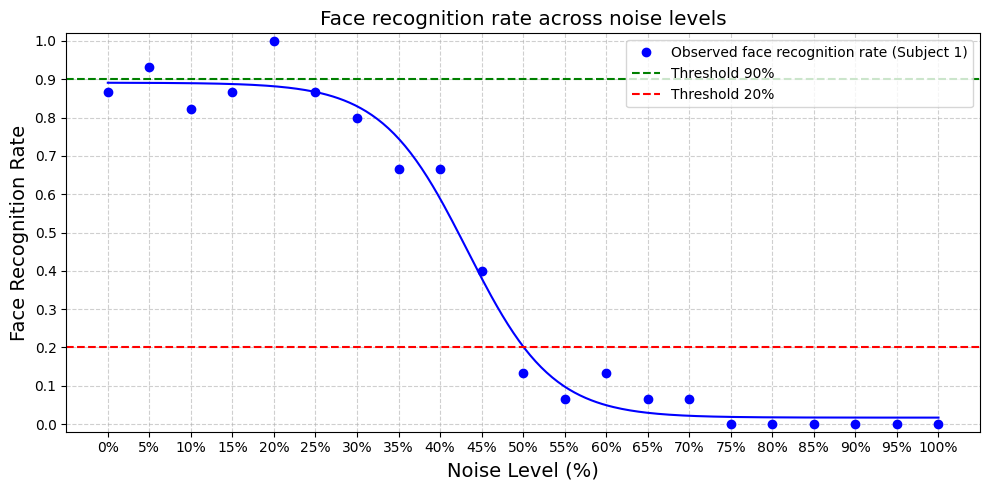

In [31]:
utils.fit_plot_sigmoid_curve([subject_idx], 'face_recognition_rate', key_args, modif=True)
ax = plt.gca()
plt.axhline(0.90, linestyle='--', color='green', label='Threshold 90%')
plt.axhline(0.20, linestyle='--', color='red', label='Threshold 20%')
plt.legend(loc='upper right', fontsize='medium')
plt.show()

In [32]:
utils.display_face_recognition_counts(selected_subject, key_args)

In [33]:
grouped_noise_vals = [                  # Noise level groups (must be sorted in ascending order)
                    [0], 
                    [5,10],
                    [15,20],
                    [25,30],
                    [35,40,45,50],
                ]
grouped_noise_dict = utils.make_noise_combinations_dict(grouped_noise_vals)

utils.display_face_recognition_counts(selected_subject, key_args, grouped_noise_dict)


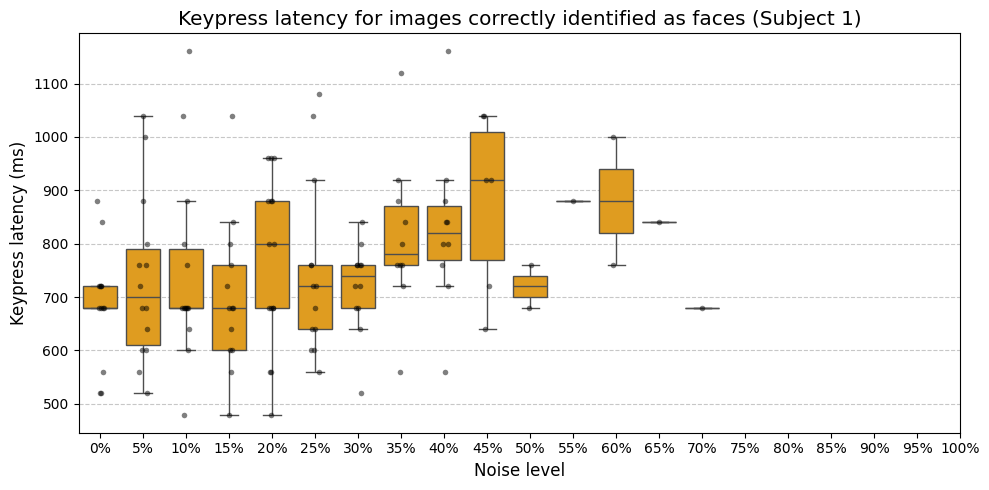

In [34]:
utils.plot_interval_keypress_recog_faces(selected_subject, key_args)

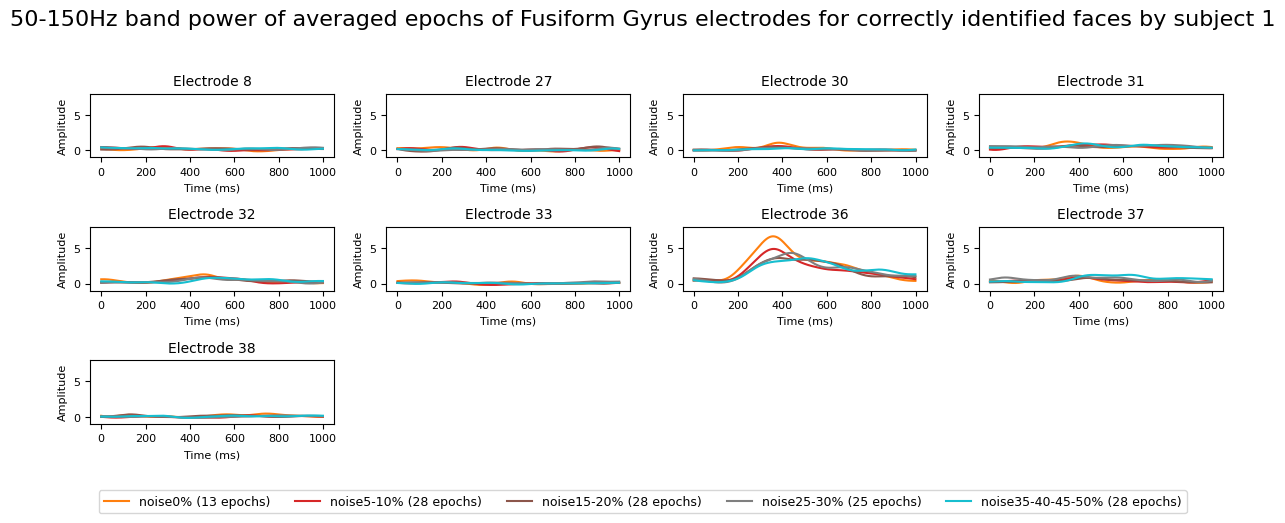

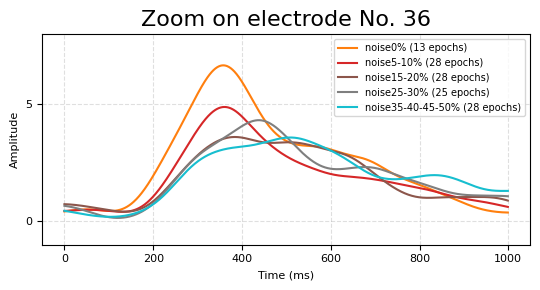

In [35]:
freq_down, freq_up = 50, 150
smooth_power = 5

#Defining grouped noise categories
grouped_noise_vals = [               # Noise level groups (must be sorted in ascending order)
                    [0], 
                    [5,10],
                    [15,20],
                    [25,30],
                    [35,40,45,50],
                ]
grouped_noise_dict = utils.make_noise_combinations_dict(grouped_noise_vals)
grouped_noise_labels = list(grouped_noise_dict.keys())

#Selecting gyrus electrodes to analyse:
gyrus='Fusiform Gyrus'

#Figure settings:
ylim = (-1, 8)
figsize = (12, 5)

#Power for all electrodes:
power_epochs_averaged_allelec, power_epochs_allelec = utils.get_power_epochs(
    selected_subject,
    freq_down,
    freq_up,
    smooth_power,
    grouped_noise_dict,
    epoch_start_wrt_image_onset = 0,
    epoch_end_wrt_image_onset = 1000,
    gyrus=gyrus,
    category='face',
    key_pressed=1,
    minimum_epochs_to_average=5,
    plot_averaged_power_by_noise=True,
    ylim=ylim,
    figsize=figsize,
    zoom_electrode_idx=[35,0,1000]
)

noise0%              : first peak slope = 0.0285 (95% CI 0.0198 - 0.0399)
noise5-10%           : first peak slope = 0.0211 (95% CI 0.0173 - 0.0260)
noise15-20%          : first peak slope = 0.0136 (95% CI 0.0086 - 0.0182)
noise25-30%          : first peak slope = 0.0142 (95% CI 0.0114 - 0.0184)
noise35-40-45-50%    : first peak slope = 0.0092 (95% CI 0.0075 - 0.0171)


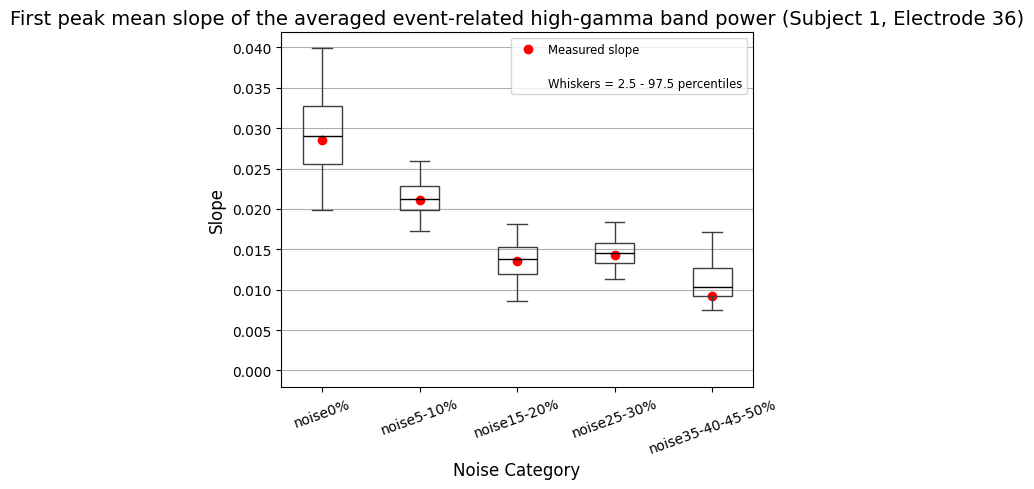

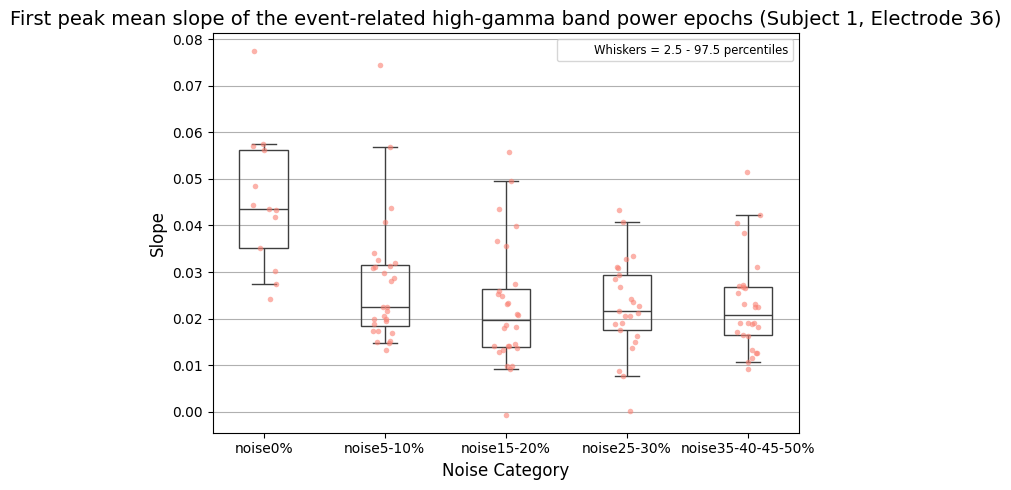

Observed Correlation : -0.3131
p-value permutation (1000 permutations) : 0.00000


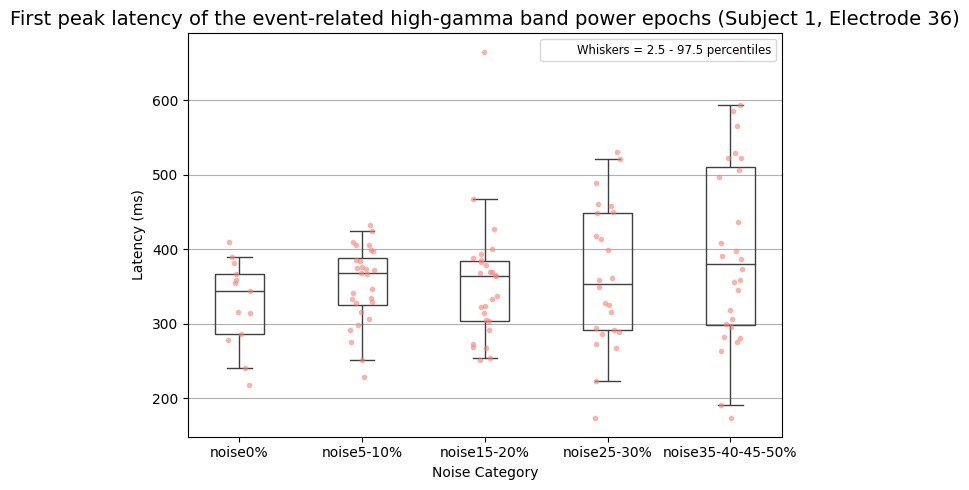

Observed Correlation : 0.1480
p-value permutation (1000 permutations) : 0.09600


In [36]:
#Studied electrode = electrode 36

elec_idx = 35

power_epochs_averaged_oneelec, power_epochs_oneelec = utils.get_power_epochs_oneelec(power_epochs_allelec, elec_idx)

power_slope_first_peak_averagedepochs = utils.get_FirstPeakPowerSlope_AveragedEpochs(power_epochs_averaged_oneelec, plot=False)
boostraps_slopes = utils.get_bootstraps(power_epochs_oneelec, N=10000)
utils.plot_power_slope_averagedepochs_with_bootstrapping(power_slope_first_peak_averagedepochs, boostraps_slopes, subject_idx, elec_idx)
_, power_slope_first_peak_individualepochs = utils.get_FirstPeakPowerSlope_IndividualEpochs(power_epochs_oneelec, subject_idx, elec_idx, plot=True)
corr_obs, p_val = utils.spearman_permutation_test(power_slope_first_peak_individualepochs, feature_str='Slope', n_perm=1000, seed=seed)

_, power_latency_first_peak_individualepochs = utils.get_FirstPeakPowerLatency_IndividualEpochs(power_epochs_oneelec, subject_idx, elec_idx, seed_examples=seed, plot_examples=False, plot=True)
corr_obs, p_val = utils.spearman_permutation_test(power_latency_first_peak_individualepochs, feature_str='Latency', n_perm=1000, seed=seed)
